In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from data.dataloader import MyDataLoader
from models.convhypernet import ConvHyperNet
from models.baselines import ConvNet
from models.hyperfusenet import HyperFuseNet

In [2]:
# Get features
def get_features(model, loader, level='encoder'):
    model.eval()
    model.to('cuda')
    features = []
    labels = []
    for data, y in tqdm(loader, desc='Extracting features', total=len(loader)):
        eye, gsr, eeg, ecg = data  # Tensors
        eye, gsr, eeg, ecg = eye.to('cuda'), gsr.to('cuda'), eeg.to('cuda'), ecg.to('cuda')
        feats = model.get_features(eye, gsr, eeg, ecg, level).detach().cpu().numpy()
        features.append(feats)
        labels.append(y.detach().numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def get_models_features(dataset):
    # Load the data
    train_file = f'G:/.shortcut-targets-by-id/1a4C1sZZVLYPHnSjH1T4GtC0Fr5t7E_bb/MAHNOB Dataset/hci-tagging-database/Torch_datasets/Train_Data_full-eye-GSR-NO-BASE_augm-scale+noise_m30_SNR5_{dataset}.pt'
    test_file = f'G:/.shortcut-targets-by-id/1a4C1sZZVLYPHnSjH1T4GtC0Fr5t7E_bb/MAHNOB Dataset/hci-tagging-database/Torch_datasets/Test_size-0.2_Data_full-eye-GSR-NO-BASE_augm-scale+noise_m30_SNR5_{dataset}.pt'
    train_loader, eval_loader, sample_weights = MyDataLoader(train_file=train_file, test_file=test_file, train_batch_size=32, test_batch_size=32, num_workers=1)

    # Weight paths
    if dataset == 'Arsl':
        conv_enc_weights = 'checkpoints/best_usual-glade-22.pt'
        hyperfusenet_weights = 'checkpoints/best_confused-grass-1.pt'
        convhypernet_weights = 'checkpoints/best_good-aardvark-26.pt'
    elif dataset == 'Vlnc':
        conv_enc_weights = 'checkpoints/best_avid-sun-48.pt'
        hyperfusenet_weights = 'checkpoints/best_glowing-lion-49.pt'
        convhypernet_weights = 'checkpoints/best_elated-dragon-36.pt'
    
    # Load the models
    conv_enc_model_weights = torch.load(conv_enc_weights, map_location='cpu')
    conv_enc_model = ConvNet(dropout_rate=0.5)
    conv_enc_model.load_state_dict(conv_enc_model_weights)
    conv_enc_model.eval()

    # Load weights of hyperfusenet and convhypernet (proposed)
    # for now let's try arousal otherwise need to train hyperfusenet for valence since we don't have a checkpoint for it
    # valence might be better since convhypernet works very well for valence
    hyperfusenet_weights = torch.load(hyperfusenet_weights, map_location='cpu')
    hyperfusenet = HyperFuseNet(dropout_rate=0.5)
    hyperfusenet.load_state_dict(hyperfusenet_weights)
    hyperfusenet.eval()

    convhypernet_weights = torch.load(convhypernet_weights, map_location='cpu')
    convhypernet = ConvHyperNet(dropout_rate=0.5)
    convhypernet.load_state_dict(convhypernet_weights)
    convhypernet.eval();

    # Get features
    conv_enc_model_features, _ = get_features(conv_enc_model, eval_loader, level='classifier')
    hyperfusenet_features, labels = get_features(hyperfusenet, eval_loader, level='classifier')
    convhypernet_features, _ = get_features(convhypernet, eval_loader, level='classifier')
    return conv_enc_model_features, hyperfusenet_features, convhypernet_features, labels

In [3]:
Arsl_conv_enc_model_features, Arsl_hyperfusenet_features, Arsl_convhypernet_features, Arsl_labels = get_models_features('Arsl')
Vlnc_conv_enc_model_features, Vlnc_hyperfusenet_features, Vlnc_convhypernet_features, Vlnc_labels = get_models_features('Vlnc')

----Loading dataset----
Dataset: MAHNOB-HCI
#Traning samples:  36360
#Validation samples:  304
#Training distribution:  [13230 14820  8310]
-------------------------


Extracting features: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


----Loading dataset----
Dataset: MAHNOB-HCI
#Traning samples:  36360
#Validation samples:  304
#Training distribution:  [12450 14880  9030]
-------------------------


Extracting features: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


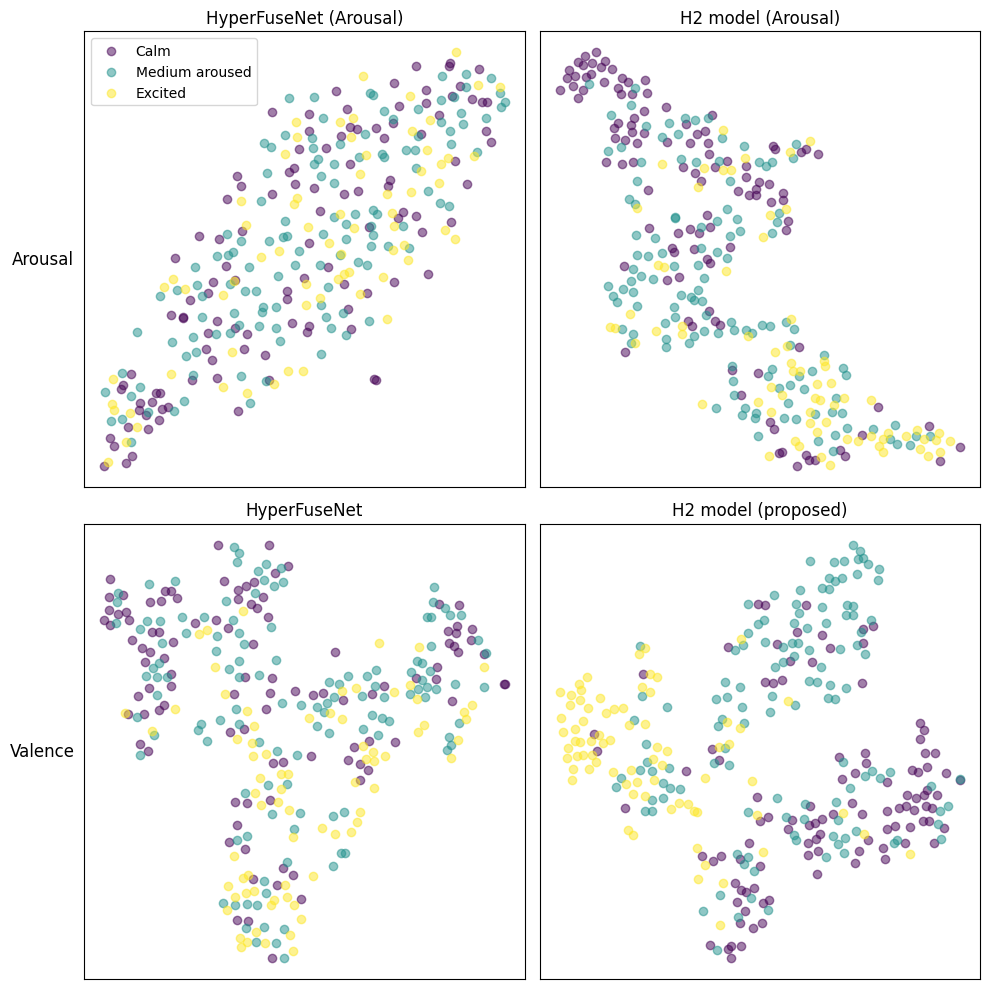

In [11]:
# Assuming you have your data and trained classifiers
# Let's say X_train contains your training data and y_train contains corresponding labels

# Assuming clf1 and clf2 are your trained classifiers
# Assuming you can obtain feature representations from both classifiers

# Assuming feature representations are stored in X_features1 and X_features2
# X_features1 and X_features2 should have the same number of samples and same dimensionality

Arsl_X_features1 = Arsl_hyperfusenet_features
Arsl_X_features2 = Arsl_convhypernet_features
Arsl_y_train = Arsl_labels

Vlnc_X_features1 = Vlnc_hyperfusenet_features
Vlnc_X_features2 = Vlnc_convhypernet_features
Vlnc_y_train = Vlnc_labels

# Combine feature representations from both classifiers
Arsl_X_combined = np.concatenate((Arsl_X_features1, Arsl_X_features2), axis=1)
Vlnc_X_combined = np.concatenate((Vlnc_X_features1, Vlnc_X_features2), axis=1)

# Create a new label array that distinguishes between the two classifiers
# clf_labels = np.concatenate((np.zeros(X_features1.shape[0]), np.ones(X_features2.shape[0])))

# Apply t-SNE to reduce dimensionality to 2D for both feature sets
tsne = TSNE(n_components=2, random_state=42)
Arsl_X_tsne1 = tsne.fit_transform(Arsl_X_features1)
Arsl_X_tsne2 = tsne.fit_transform(Arsl_X_features2)

tsne = TSNE(n_components=2, random_state=42)
Vlnc_X_tsne1 = tsne.fit_transform(Vlnc_X_features1)
Vlnc_X_tsne2 = tsne.fit_transform(Vlnc_X_features2)

# Create a colormap
cmap = plt.cm.viridis

# Assuming you have n unique labels in y_train
unique_labels = np.unique(Arsl_y_train)
colors = [cmap(i) for i in np.linspace(0, 1, len(unique_labels))]

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

Arsl_class_names = ['Calm', 'Medium aroused', 'Excited']
Vlnc_class_names = ['Unpleast', 'Neutral', 'Pleasant']

# Plot the t-SNE embeddings for Classifier 1 (Arousal)
for i, label in enumerate(unique_labels):
    axs[0, 0].scatter(Arsl_X_tsne1[Arsl_y_train == label, 0], Arsl_X_tsne1[Arsl_y_train == label, 1], color=colors[i], alpha=0.5, label=Arsl_class_names[label])
axs[0, 0].legend()
axs[0, 0].set_title('HyperFuseNet (Arousal)')
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].set_ylabel('Arousal', rotation=0, labelpad=30, verticalalignment='center', fontsize=12)

# Plot the t-SNE embeddings for Classifier 2 (Arousal)
for i, label in enumerate(unique_labels):
    axs[0, 1].scatter(Arsl_X_tsne2[Arsl_y_train == label, 0], Arsl_X_tsne2[Arsl_y_train == label, 1], color=colors[i], alpha=0.5, label=Arsl_class_names[label])
axs[0, 1].set_title('H2 model (Arousal)')
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])



# Plot the t-SNE embeddings for Classifier 1 (Valence)
# Assuming X_tsne1_valence and X_tsne2_valence are the t-SNE embeddings for Valence
for i, label in enumerate(unique_labels):
    axs[1, 0].scatter(Vlnc_X_tsne1[Vlnc_y_train == label, 0], Vlnc_X_tsne1[Vlnc_y_train == label, 1], color=colors[i], alpha=0.5, label=Vlnc_class_names[label])
axs[1, 0].set_title('HyperFuseNet')
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
axs[1, 0].set_ylabel('Valence', rotation=0, labelpad=30, verticalalignment='center', fontsize=12)

# Plot the t-SNE embeddings for Classifier 2 (Valence)
for i, label in enumerate(unique_labels):
    axs[1, 1].scatter(Vlnc_X_tsne2[Vlnc_y_train == label, 0], Vlnc_X_tsne2[Vlnc_y_train == label, 1], color=colors[i], alpha=0.5, label=Vlnc_class_names[label])
axs[1, 1].set_title('H2 model (proposed)')
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

plt.tight_layout()
plt.show()

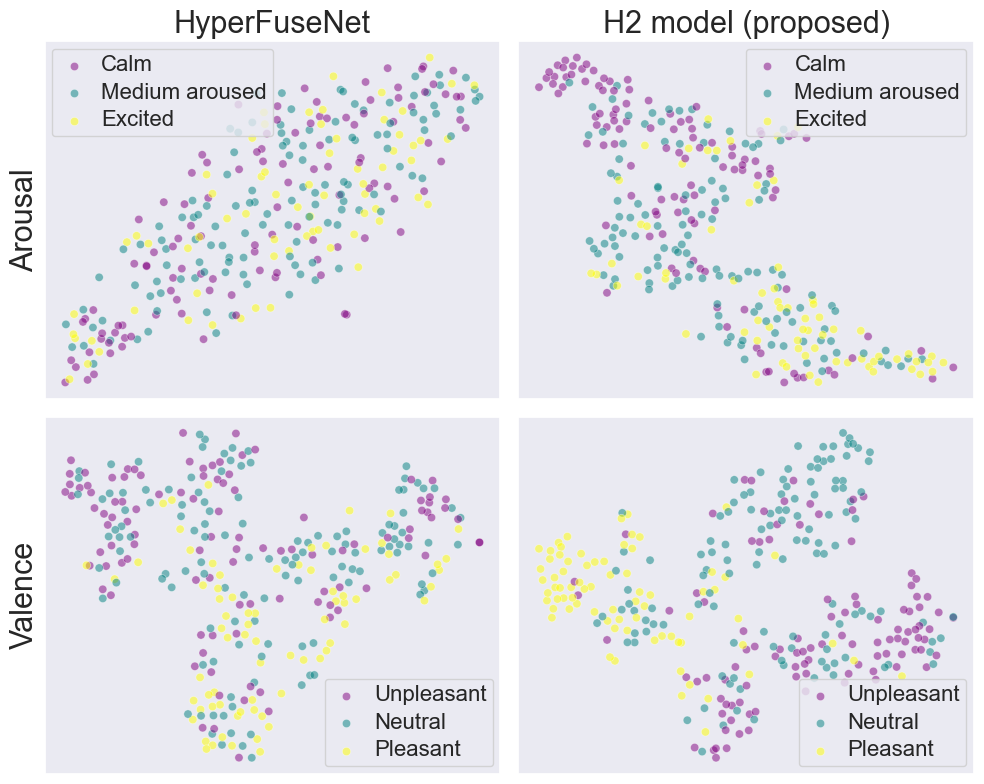

In [54]:
import seaborn as sns
import pandas as pd

sns.set(style='dark')

Arsl_X_features1 = Arsl_hyperfusenet_features
Arsl_X_features2 = Arsl_convhypernet_features
Arsl_y_train = Arsl_labels

Vlnc_X_features1 = Vlnc_hyperfusenet_features
Vlnc_X_features2 = Vlnc_convhypernet_features
Vlnc_y_train = Vlnc_labels

# Combine feature representations from both classifiers
Arsl_X_combined = np.concatenate((Arsl_X_features1, Arsl_X_features2), axis=1)
Vlnc_X_combined = np.concatenate((Vlnc_X_features1, Vlnc_X_features2), axis=1)

# Create a new label array that distinguishes between the two classifiers
# clf_labels = np.concatenate((np.zeros(X_features1.shape[0]), np.ones(X_features2.shape[0])))

# Apply t-SNE to reduce dimensionality to 2D for both feature sets
tsne = TSNE(n_components=2, random_state=42)
Arsl_X_tsne1 = tsne.fit_transform(Arsl_X_features1)
Arsl_X_tsne2 = tsne.fit_transform(Arsl_X_features2)

tsne = TSNE(n_components=2, random_state=42)
Vlnc_X_tsne1 = tsne.fit_transform(Vlnc_X_features1)
Vlnc_X_tsne2 = tsne.fit_transform(Vlnc_X_features2)

Arsl_class_names = ['Calm', 'Medium aroused', 'Excited']
Vlnc_class_names = ['Unpleasant', 'Neutral', 'Pleasant']

# Prepare data for seaborn
Arsl_df1 = pd.DataFrame(Arsl_X_tsne1, columns=['Dimension 1', 'Dimension 2'])
Arsl_df1['Label'] = [Arsl_class_names[i] for i in Arsl_y_train]

Arsl_df2 = pd.DataFrame(Arsl_X_tsne2, columns=['Dimension 1', 'Dimension 2'])
Arsl_df2['Label'] = [Arsl_class_names[i] for i in Arsl_y_train]

Vlnc_df1 = pd.DataFrame(Vlnc_X_tsne1, columns=['Dimension 1', 'Dimension 2'])
Vlnc_df1['Label'] = [Vlnc_class_names[i] for i in Vlnc_y_train]

Vlnc_df2 = pd.DataFrame(Vlnc_X_tsne2, columns=['Dimension 1', 'Dimension 2'])
Vlnc_df2['Label'] = [Vlnc_class_names[i] for i in Vlnc_y_train]

# Define your color dictionary
Arsl_color_dict = {'Calm': 'purple', 'Medium aroused': 'teal', 'Excited': 'yellow'}
Vlnc_color_dict = {'Unpleasant': 'purple', 'Neutral': 'teal', 'Pleasant': 'yellow'}

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the t-SNE embeddings for Classifier 1 (Arousal)
sns.scatterplot(data=Arsl_df1, x='Dimension 1', y='Dimension 2', hue='Label', palette=Arsl_color_dict, alpha=0.5, ax=axs[0, 0])
axs[0, 0].set_title('HyperFuseNet', fontsize=22)
axs[0, 0].set(xlabel='')
axs[0, 0].set_ylabel('Arousal', fontsize=22)
axs[0, 0].xaxis.set_ticks([])
axs[0, 0].yaxis.set_ticks([])
legend = axs[0, 0].legend(loc='upper left')  # Move the legend to the upper right
legend.set_title('')
for text in legend.texts:
    text.set_fontsize(16)

# Plot the t-SNE embeddings for Classifier 2 (Arousal)
sns.scatterplot(data=Arsl_df2, x='Dimension 1', y='Dimension 2', hue='Label', palette=Arsl_color_dict, alpha=0.5, ax=axs[0, 1])
axs[0, 1].set_title('H2 model (proposed)', fontsize=22)
axs[0, 1].set(xlabel='', ylabel='')
axs[0, 1].xaxis.set_ticks([])
axs[0, 1].yaxis.set_ticks([])
legend = axs[0, 1].get_legend()
legend.set_title('')
for text in legend.texts:
    text.set_fontsize(16)

# Specify the order of the legend entries
hue_order = ['Unpleasant', 'Neutral', 'Pleasant']

# Plot the t-SNE embeddings for Classifier 1 (Valence)
sns.scatterplot(data=Vlnc_df1, x='Dimension 1', y='Dimension 2', hue='Label', palette=Vlnc_color_dict, alpha=0.5, ax=axs[1, 0], hue_order=hue_order)
# axs[1, 0].set_title('HyperFuseNet (Valence)')
axs[1, 0].set(xlabel='')
axs[1, 0].set_ylabel('Valence', fontsize=22)
axs[1, 0].xaxis.set_ticks([])
axs[1, 0].yaxis.set_ticks([])
legend = axs[1, 0].legend(loc='lower right')  # Move the legend to the bottom right
legend.set_title('')
for text in legend.texts:
    text.set_fontsize(16)

# Plot the t-SNE embeddings for Classifier 2 (Valence)
sns.scatterplot(data=Vlnc_df2, x='Dimension 1', y='Dimension 2', hue='Label', palette=Vlnc_color_dict, alpha=0.5, ax=axs[1, 1], hue_order=hue_order)
# axs[1, 1].set_title('HiHyperNet (Valence)')
axs[1, 1].set(xlabel='', ylabel='')
axs[1, 1].xaxis.set_ticks([])
axs[1, 1].yaxis.set_ticks([])
legend = axs[1, 1].legend(loc='lower right')
legend.set_title('')
for text in legend.texts:
    text.set_fontsize(16)

plt.tight_layout()
# Save the figure as a high-quality PDF
plt.savefig('figure_features.pdf', format='pdf', dpi=300)
plt.show()